# Causal Functional Models

This notebook provides a brief overview on the idea of Causal Functional Models (CFM) in 3 steps:
1. *Generation of artificial sample data:* 3 datasets with different (non-)linear dependencies are constructed
2. *Intro to Causal Functional Models:* the basic functions *model_graph(), train_graph() & inference()* are introduced 
3. *Test:* evaluation of CFM performance

**Abstract**  
The proposed CFM are based on a graph structure that represents knowledge about the underlying phenomena. Each node represents a variable in the examined dataset. Neural networks are used to model functional dependencies between the variables. Modeling the 'causal path' behind the data & structuring the network accordingly may yield more expressive models and facilitate validation of the assumed causal structure of the investigated phenomenom.

In [1]:
# Imports
import numpy as np 
import pandas as pd
import torch.nn as nn
import torch
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

import functional as f
import model as m

## 1. Generation of artificial sample data

The generated sample data implements the causal structure of a highly simplified, fictional laser welding experiment.  
  
  
Laser power (POWER) and welding speed (SPEED) determine the weld cross section (XSEC). Cross section and number of weld seams (NSEAMS) in turn determine the maximum force (F), which the weld joint can endure. The aim in this case would be to predict the dependent variable F from the independent variables POWER, SPEED and XSEC. 

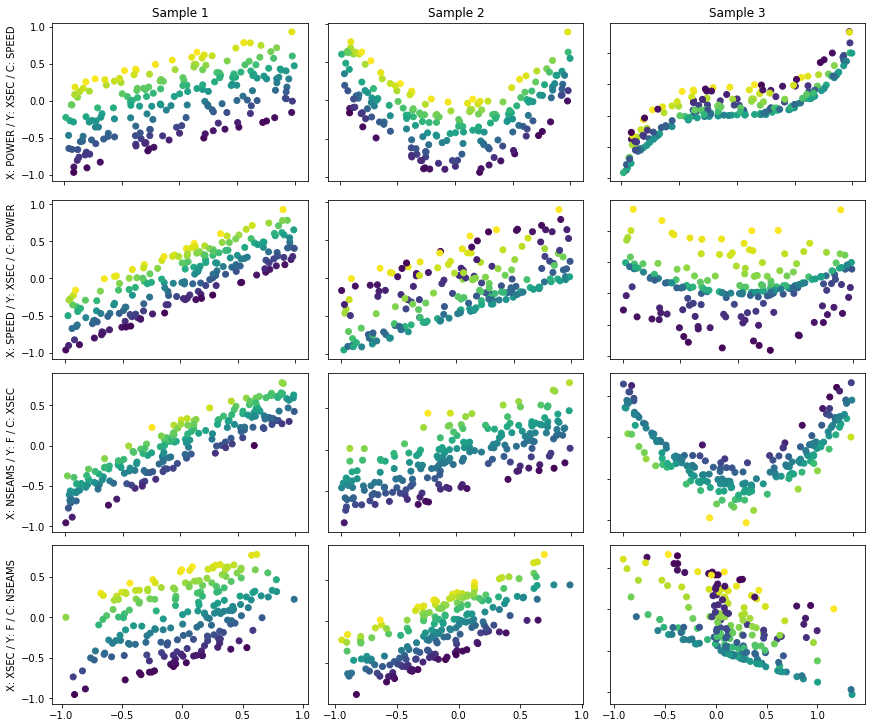

In [2]:
fig, axs = plt.subplots(4, 3, constrained_layout=True, figsize=(12, 10))

for ax in axs.flat:
    ax.label_outer()

axs[0, 0].set_ylabel('X: POWER / Y: XSEC / C: SPEED')
axs[1, 0].set_ylabel('X: SPEED / Y: XSEC / C: POWER')
axs[2, 0].set_ylabel('X: NSEAMS / Y: F / C: XSEC')
axs[3, 0].set_ylabel('X: XSEC / Y: F / C: NSEAMS')
    
def fill_subplots(smpl):
    axs[0, smpl].scatter(x12, l21, c=x13)
    axs[1, smpl].scatter(x13, l21, c=x12)
    axs[2, smpl].scatter(x11, d31, c=l21)
    axs[3, smpl].scatter(l21, d31, c=x11)
    axs[0, smpl].set_title('Sample '+str(smpl+1))


length = 200
# independent variables
x11 = np.random.rand(length)*2 - 1
x12 = np.random.rand(length)*2 - 1
x13 = np.random.rand(length)*2 - 1

# Sample 1 (linear relation)
l21 = x12*0.4 + x13*0.6
d31 = x11*0.6 + l21*0.4
data_1 = pd.DataFrame({'NSEAMS':x11, 'POWER':x12, 'SPEED':x13, 'XSEC':l21, 'F':d31})

fill_subplots(0)

# Sample 2 (non-lin. relation)
l21 = x12**2 + x13*0.5 - 0.5
d31 = x11*0.4 + l21*0.6
data_2 = pd.DataFrame({'NSEAMS':x11, 'POWER':x12, 'SPEED':x13, 'XSEC':l21, 'F':d31})

fill_subplots(1)

# Sample 3 (highly non-lin. relation)
l21 = x12**3 + 0.5*x13**2
d31 = x11**2 - l21*0.4
data_3 = pd.DataFrame({'NSEAMS':x11, 'POWER':x12, 'SPEED':x13, 'XSEC':l21, 'F':d31})

fill_subplots(2)

In [3]:
# normalize data 
data_1_norm = ((data_1 - data_1.min())/(data_1.max() - data_1.min()))*2 - 1
data_2_norm = ((data_2 - data_2.min())/(data_2.max() - data_2.min()))*2 - 1
data_3_norm = ((data_3 - data_3.min())/(data_3.max() - data_3.min()))*2 - 1

## 2. Intro to Causal Functional Models (CFM)

The variable *graph* defines the causal relationship between the variables of the generated datasets. A node should only depend on inputs from previous nodes stated before itself.
  
By calling the function *m.model_graph(graph, data, val_split, batch_size, depth, activation, optimizer)* an extended copy of the given graph is returned according to the following input parameters:
- *graph:* ([dict]) specifies (the assumed) causal structure of the dataset
- *data:* (pandas dataframe) contains the dataset
- *val_split:* (int) specifies index range used for training & validation
- *batch_size:* (int) batch size used during training
- *depth:* (int) nr. of layers in the neural network models that approximate the functional relations
- *activation:* (pytorch activation function) used in the models, e.g. nn.ReLU()
- *optimizer:* (str) defines the optimizer, e.g. 'Adam'  
  
The function *f.train_graph(modeled_graph, max_epochs, criterion, early_stopping)* returns a copy of the modeled graph with the trained neural networks models, where:
- *modeled_graph:* ([dict]) is a modeled graph returned by m.model_graph()
- *max_epochs:* (int) max. nr. of training epochs
- *criterion:* (pytorch loss function) used for training of the models, e.g. nn.L1Loss()
- *early_stopping:* (bool) if True training is stopped when validation loss did not decrease for over 10 epochs
  
The function *f.inference(trained_graph, df_inputs, df_labels, metric)* can be called to perfrom inference and make predictions based on the provided data, returns pandas dataframe with predictions, where:
- *trained_graph:* ([dict]) is a modeled & trained graph returned by f.train_graph()
- *df_inputs:* (pandas dataframe) contains feature dataset 
- *df_labels:* (pandas dataframe) contains dataset with labels respectively node names to predict & ground truth data for performance measurement
- *metric:* ([str]) definition of performance metrics to measure

In [4]:
graph = [
    {
        'name': 'NSEAMS',
        'inputs': None,
    },
    {
        'name': 'POWER',
        'inputs': None,
    },
    {
        'name': 'SPEED',
        'inputs': None,
    },
    {
        'name': 'XSEC',
        'inputs': ['POWER', 'SPEED'],
    },
    {
        'name': 'F',
        'inputs': ['NSEAMS', 'XSEC'],
    }
]

modeled_graph = m.model_graph(graph, data_1, 150, 1, 3, nn.ReLU(), 'Adam')

print(modeled_graph, '\n------------------------------------------------\n')

trained_graph = f.train_graph(modeled_graph, 10, nn.L1Loss(), False)
f.inference(trained_graph, data_1[150:][['NSEAMS', 'POWER', 'SPEED']], data_1[150:][['XSEC', 'F']], ['MAE'])

[{'name': 'NSEAMS', 'inputs': None}, {'name': 'POWER', 'inputs': None}, {'name': 'SPEED', 'inputs': None}, {'name': 'XSEC', 'inputs': ['POWER', 'SPEED'], 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x7fe2bdc78f50>, 'valloader': <torch.utils.data.dataloader.DataLoader object at 0x7fe2bdc518d0>, 'model': Sequential(
  (fc_0): Linear(in_features=2, out_features=2, bias=True)
  (activation_0): ReLU()
  (fc_1): Linear(in_features=2, out_features=2, bias=True)
  (activation_1): ReLU()
  (fc_2): Linear(in_features=2, out_features=1, bias=True)
), 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)}, {'name': 'F', 'inputs': ['NSEAMS', 'XSEC'], 'trainloader': <torch.utils.data.dataloader.DataLoader object at 0x7fe2c28b9bd0>, 'valloader': <torch.utils.data.dataloader.DataLoader object at 0x7fe2c1fff950>, 'model': Sequential(
  (fc_0): Linear(in_features=2, out_features=2, bias=True)
  (activation

,XSEC,F
0,-0.045161,0.551383
1,-0.345871,-0.435965
2,0.092059,0.305029
3,-0.145639,-0.434325
4,0.092059,0.451995
5,-0.259435,-0.194583
6,0.044522,-0.063782
7,-0.317266,-0.364140
8,-0.154107,0.382372
9,-0.132477,0.464669


## 3.1.  Test: CFM against MLP

The CFM is benchmarked against a standard multi layer preceptrion (MLP) on the 3 generated datasets. 

In [5]:
valsplit = int(length*0.7)
testsplit = int(length*0.85)
results = [[],[]]
max_epochs = 100

for data in [data_1_norm, data_2_norm, data_3_norm]:
    #------------ MLP -----------------------------------------------------------------------------------
    # define MLP
    mlp = m.func_block(dim_in=3, depth=3, activation=nn.ReLU())
    optim = torch.optim.Adam(mlp.parameters())
    criterion = torch.nn.L1Loss()
    
    trainloader = m.get_dataloader(data[:valsplit], feature_cols=['NSEAMS', 'POWER', 'SPEED'],
                                    label_cols=['F'], batch_size=1)
    valloader = m.get_dataloader(data[valsplit:testsplit], feature_cols=['NSEAMS', 'POWER', 'SPEED'],
                                    label_cols=['F'], batch_size=1)   
    testloader = m.get_dataloader(data[testsplit:], feature_cols=['NSEAMS', 'POWER', 'SPEED'],
                                    label_cols=['F'], batch_size=1)   

    # train MLP
    print('\n############### MLP ###################')
    for epoch in range(max_epochs):
        train_loss = 0.0
        stat_train_loss = 0.0 
        test_loss = 0.0
        stat_test_loss = 0.0

        mlp.train()
        for _, (features, labels) in enumerate(trainloader):
            optim.zero_grad()
            out = mlp(features)    
            train_loss = criterion(out, labels)
            train_loss.backward()
            optim.step()
            stat_train_loss += train_loss.item()

        mlp.eval()
        for _, (features, labels) in enumerate(valloader):     
            out = mlp(features)  
            test_loss = criterion(out, labels)
            stat_test_loss += test_loss.item()
  
        print(' Ep', epoch, '\tTrain Loss:',
            round(stat_train_loss/len(trainloader),5), '\tVal. Loss:',
            round(stat_test_loss/len(valloader), 5))
   
    # test MLP
    mlp_pred = []
    for _, (features, labels) in enumerate(testloader):     
        out = mlp(features)  
        mlp_pred.append(out)
    
    acc_mlp = metrics.mean_absolute_error(data[testsplit:][['F']].to_numpy(), np.array(mlp_pred))
    results[0].append(acc_mlp)


    #------------ CFM -----------------------------------------------------------------------------------
    print('\n############### CFM ###################')
    modeled_graph = m.model_graph(graph, data[:testsplit], valsplit, 1, 3, nn.ReLU(), 'Adam')
    trained_graph = f.train_graph(modeled_graph, max_epochs, nn.L1Loss(), False)           
    pred = f.inference(trained_graph, data[testsplit:][['NSEAMS', 'POWER', 'SPEED']], 
                        data[testsplit:][['XSEC', 'F']], ['MAE'])
    
    acc_cfm = metrics.mean_absolute_error(data[testsplit:][['F']].to_numpy(), pred[['F']].to_numpy())
    results[1].append(acc_cfm)


############### MLP ###################
 Ep 0 	Train Loss: 0.37027 	Val. Loss: 0.41725
 Ep 1 	Train Loss: 0.33811 	Val. Loss: 0.38268
 Ep 2 	Train Loss: 0.30211 	Val. Loss: 0.33446
 Ep 3 	Train Loss: 0.25716 	Val. Loss: 0.27453
 Ep 4 	Train Loss: 0.20276 	Val. Loss: 0.21159
 Ep 5 	Train Loss: 0.14597 	Val. Loss: 0.1559
 Ep 6 	Train Loss: 0.11794 	Val. Loss: 0.13437
 Ep 7 	Train Loss: 0.10164 	Val. Loss: 0.11893
 Ep 8 	Train Loss: 0.08803 	Val. Loss: 0.10277
 Ep 9 	Train Loss: 0.07734 	Val. Loss: 0.09096
 Ep 10 	Train Loss: 0.06861 	Val. Loss: 0.07987
 Ep 11 	Train Loss: 0.06015 	Val. Loss: 0.07321
 Ep 12 	Train Loss: 0.05328 	Val. Loss: 0.06779
 Ep 13 	Train Loss: 0.0475 	Val. Loss: 0.06102
 Ep 14 	Train Loss: 0.04315 	Val. Loss: 0.05645
 Ep 15 	Train Loss: 0.03867 	Val. Loss: 0.05266
 Ep 16 	Train Loss: 0.03587 	Val. Loss: 0.04895
 Ep 17 	Train Loss: 0.03215 	Val. Loss: 0.0437
 Ep 18 	Train Loss: 0.03113 	Val. Loss: 0.04052
 Ep 19 	Train Loss: 0.02832 	Val. Loss: 0.03615
 Ep 20 	Trai

 Ep 69 	Train Loss: 0.00546 	Val. Loss: 0.00605
 Ep 70 	Train Loss: 0.00527 	Val. Loss: 0.00626
 Ep 71 	Train Loss: 0.00576 	Val. Loss: 0.00644
 Ep 72 	Train Loss: 0.0062 	Val. Loss: 0.00748
 Ep 73 	Train Loss: 0.00581 	Val. Loss: 0.00607
 Ep 74 	Train Loss: 0.00452 	Val. Loss: 0.00594
 Ep 75 	Train Loss: 0.00544 	Val. Loss: 0.00461
 Ep 76 	Train Loss: 0.00514 	Val. Loss: 0.00945
 Ep 77 	Train Loss: 0.00668 	Val. Loss: 0.00932
 Ep 78 	Train Loss: 0.00581 	Val. Loss: 0.00707
 Ep 79 	Train Loss: 0.00617 	Val. Loss: 0.0053
 Ep 80 	Train Loss: 0.00567 	Val. Loss: 0.00476
 Ep 81 	Train Loss: 0.00529 	Val. Loss: 0.00814
 Ep 82 	Train Loss: 0.00534 	Val. Loss: 0.00611
 Ep 83 	Train Loss: 0.005 	Val. Loss: 0.00902
 Ep 84 	Train Loss: 0.00549 	Val. Loss: 0.00654
 Ep 85 	Train Loss: 0.00505 	Val. Loss: 0.00679
 Ep 86 	Train Loss: 0.00565 	Val. Loss: 0.00736
 Ep 87 	Train Loss: 0.00591 	Val. Loss: 0.00429
 Ep 88 	Train Loss: 0.00501 	Val. Loss: 0.0048
 Ep 89 	Train Loss: 0.00554 	Val. Loss: 0.005

 Ep 39 	Train Loss: 0.17858 	Val. Loss: 0.19905
 Ep 40 	Train Loss: 0.17793 	Val. Loss: 0.19806
 Ep 41 	Train Loss: 0.17821 	Val. Loss: 0.19856
 Ep 42 	Train Loss: 0.17823 	Val. Loss: 0.19889
 Ep 43 	Train Loss: 0.17816 	Val. Loss: 0.19747
 Ep 44 	Train Loss: 0.1781 	Val. Loss: 0.1962
 Ep 45 	Train Loss: 0.17679 	Val. Loss: 0.19966
 Ep 46 	Train Loss: 0.17796 	Val. Loss: 0.19986
 Ep 47 	Train Loss: 0.17786 	Val. Loss: 0.19869
 Ep 48 	Train Loss: 0.17782 	Val. Loss: 0.19747
 Ep 49 	Train Loss: 0.17729 	Val. Loss: 0.19944
 Ep 50 	Train Loss: 0.17752 	Val. Loss: 0.19803
 Ep 51 	Train Loss: 0.17644 	Val. Loss: 0.19913
 Ep 52 	Train Loss: 0.17745 	Val. Loss: 0.19818
 Ep 53 	Train Loss: 0.177 	Val. Loss: 0.20021
 Ep 54 	Train Loss: 0.17676 	Val. Loss: 0.20097
 Ep 55 	Train Loss: 0.177 	Val. Loss: 0.20219
 Ep 56 	Train Loss: 0.1779 	Val. Loss: 0.19967
 Ep 57 	Train Loss: 0.17686 	Val. Loss: 0.19909
 Ep 58 	Train Loss: 0.17684 	Val. Loss: 0.19794
 Ep 59 	Train Loss: 0.17562 	Val. Loss: 0.20115

 Ep 9 	Train Loss: 0.19827 	Val. Loss: 0.16649
 Ep 10 	Train Loss: 0.14779 	Val. Loss: 0.12795
 Ep 11 	Train Loss: 0.12479 	Val. Loss: 0.10981
 Ep 12 	Train Loss: 0.11254 	Val. Loss: 0.09543
 Ep 13 	Train Loss: 0.10019 	Val. Loss: 0.08323
 Ep 14 	Train Loss: 0.09026 	Val. Loss: 0.07322
 Ep 15 	Train Loss: 0.08132 	Val. Loss: 0.06693
 Ep 16 	Train Loss: 0.0743 	Val. Loss: 0.05938
 Ep 17 	Train Loss: 0.06729 	Val. Loss: 0.05321
 Ep 18 	Train Loss: 0.06073 	Val. Loss: 0.04819
 Ep 19 	Train Loss: 0.05426 	Val. Loss: 0.04272
 Ep 20 	Train Loss: 0.04866 	Val. Loss: 0.03802
 Ep 21 	Train Loss: 0.04446 	Val. Loss: 0.03452
 Ep 22 	Train Loss: 0.04023 	Val. Loss: 0.03105
 Ep 23 	Train Loss: 0.03651 	Val. Loss: 0.02789
 Ep 24 	Train Loss: 0.03365 	Val. Loss: 0.02462
 Ep 25 	Train Loss: 0.03055 	Val. Loss: 0.02437
 Ep 26 	Train Loss: 0.02817 	Val. Loss: 0.02121
 Ep 27 	Train Loss: 0.02582 	Val. Loss: 0.0204
 Ep 28 	Train Loss: 0.02395 	Val. Loss: 0.01738
 Ep 29 	Train Loss: 0.02284 	Val. Loss: 0.0

 Ep 79 	Train Loss: 0.11065 	Val. Loss: 0.11494
 Ep 80 	Train Loss: 0.11045 	Val. Loss: 0.11257
 Ep 81 	Train Loss: 0.1097 	Val. Loss: 0.11104
 Ep 82 	Train Loss: 0.10928 	Val. Loss: 0.1117
 Ep 83 	Train Loss: 0.10793 	Val. Loss: 0.10865
 Ep 84 	Train Loss: 0.10696 	Val. Loss: 0.10777
 Ep 85 	Train Loss: 0.10668 	Val. Loss: 0.10567
 Ep 86 	Train Loss: 0.10699 	Val. Loss: 0.10537
 Ep 87 	Train Loss: 0.10667 	Val. Loss: 0.10238
 Ep 88 	Train Loss: 0.10624 	Val. Loss: 0.10227
 Ep 89 	Train Loss: 0.10608 	Val. Loss: 0.10195
 Ep 90 	Train Loss: 0.10581 	Val. Loss: 0.09954
 Ep 91 	Train Loss: 0.105 	Val. Loss: 0.09914
 Ep 92 	Train Loss: 0.10326 	Val. Loss: 0.10037
 Ep 93 	Train Loss: 0.10488 	Val. Loss: 0.09903
 Ep 94 	Train Loss: 0.10482 	Val. Loss: 0.0991
 Ep 95 	Train Loss: 0.10399 	Val. Loss: 0.09917
 Ep 96 	Train Loss: 0.103 	Val. Loss: 0.09811
 Ep 97 	Train Loss: 0.10169 	Val. Loss: 0.09535
 Ep 98 	Train Loss: 0.10222 	Val. Loss: 0.09605
 Ep 99 	Train Loss: 0.10281 	Val. Loss: 0.09536

 Ep 49 	Train Loss: 0.07021 	Val. Loss: 0.08318
 Ep 50 	Train Loss: 0.06928 	Val. Loss: 0.08262
 Ep 51 	Train Loss: 0.0704 	Val. Loss: 0.08085
 Ep 52 	Train Loss: 0.06951 	Val. Loss: 0.08007
 Ep 53 	Train Loss: 0.06881 	Val. Loss: 0.07964
 Ep 54 	Train Loss: 0.06871 	Val. Loss: 0.07871
 Ep 55 	Train Loss: 0.06882 	Val. Loss: 0.07779
 Ep 56 	Train Loss: 0.06858 	Val. Loss: 0.07722
 Ep 57 	Train Loss: 0.06797 	Val. Loss: 0.07675
 Ep 58 	Train Loss: 0.06768 	Val. Loss: 0.07644
 Ep 59 	Train Loss: 0.06867 	Val. Loss: 0.07658
 Ep 60 	Train Loss: 0.06899 	Val. Loss: 0.07581
 Ep 61 	Train Loss: 0.06801 	Val. Loss: 0.07512
 Ep 62 	Train Loss: 0.06794 	Val. Loss: 0.07513
 Ep 63 	Train Loss: 0.0677 	Val. Loss: 0.0745
 Ep 64 	Train Loss: 0.06744 	Val. Loss: 0.07397
 Ep 65 	Train Loss: 0.06747 	Val. Loss: 0.07338
 Ep 66 	Train Loss: 0.06705 	Val. Loss: 0.07325
 Ep 67 	Train Loss: 0.06707 	Val. Loss: 0.07321
 Ep 68 	Train Loss: 0.06711 	Val. Loss: 0.07317
 Ep 69 	Train Loss: 0.06666 	Val. Loss: 0.0

[0.004524943489048281, 0.18465955444042811, 0.1257333037143344]
[0.006764456736954958, 0.1663183485267535, 0.09340835976956982]


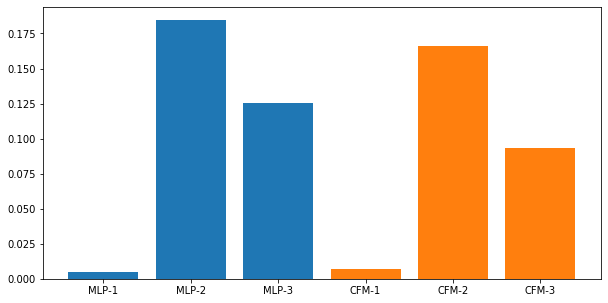

In [6]:
print(results[0])
print(results[1])

fig = plt.figure(figsize=(10,5))
fig = plt.bar(x=['MLP-1', 'MLP-2', 'MLP-3'], height=results[0])
fig = plt.bar(x=['CFM-1', 'CFM-2', 'CFM-3'], height=results[1])

## 3.2. Test: CFM with slightly false causal structure



In [7]:
wrong_graph = [
    {
        'name': 'NSEAMS',
        'inputs': None,
    },
    {
        'name': 'POWER',
        'inputs': None,
    },
    {
        'name': 'SPEED',
        'inputs': None,
    },
    {
        'name': 'XSEC',
        'inputs': ['POWER', 'SPEED', 'NSEAMS'],
    },
    {
        'name': 'F',
        'inputs': ['SPEED', 'XSEC'],
    }
]

In [8]:
w_res = []
for data in [data_1, data_2, data_3]:
    w_modeled_graph = m.model_graph(graph, data[:testsplit], valsplit, 1, 3, nn.ReLU(), 'Adam')
    w_trained_graph = f.train_graph(modeled_graph, max_epochs, nn.L1Loss(), False)           
    w_pred = f.inference(trained_graph, data[testsplit:][['NSEAMS', 'POWER', 'SPEED']], 
                            data[testsplit:][['XSEC', 'F']], ['MAE'])

    w_acc_cfm = metrics.mean_absolute_error(data[testsplit:][['F']].to_numpy(), pred[['F']].to_numpy())
    w_res.append(w_acc_cfm)


TRAINING:
 ------------------	 XSEC 	------------------
 Ep 0 	Train Loss: 0.30516 	Val. Loss: 0.27551
 Ep 1 	Train Loss: 0.28909 	Val. Loss: 0.26299
 Ep 2 	Train Loss: 0.28151 	Val. Loss: 0.25545
 Ep 3 	Train Loss: 0.27689 	Val. Loss: 0.25094
 Ep 4 	Train Loss: 0.27405 	Val. Loss: 0.24934
 Ep 5 	Train Loss: 0.27156 	Val. Loss: 0.247
 Ep 6 	Train Loss: 0.26935 	Val. Loss: 0.24567
 Ep 7 	Train Loss: 0.26756 	Val. Loss: 0.24338
 Ep 8 	Train Loss: 0.26509 	Val. Loss: 0.2398
 Ep 9 	Train Loss: 0.2616 	Val. Loss: 0.23779
 Ep 10 	Train Loss: 0.25788 	Val. Loss: 0.23499
 Ep 11 	Train Loss: 0.25349 	Val. Loss: 0.23133
 Ep 12 	Train Loss: 0.24847 	Val. Loss: 0.22901
 Ep 13 	Train Loss: 0.24187 	Val. Loss: 0.22642
 Ep 14 	Train Loss: 0.23454 	Val. Loss: 0.22023
 Ep 15 	Train Loss: 0.22652 	Val. Loss: 0.21466
 Ep 16 	Train Loss: 0.21911 	Val. Loss: 0.20556
 Ep 17 	Train Loss: 0.21169 	Val. Loss: 0.19545
 Ep 18 	Train Loss: 0.20621 	Val. Loss: 0.19165
 Ep 19 	Train Loss: 0.20046 	Val. Loss: 0.186

 Ep 70 	Train Loss: 0.06658 	Val. Loss: 0.07233
 Ep 71 	Train Loss: 0.06634 	Val. Loss: 0.07234
 Ep 72 	Train Loss: 0.06678 	Val. Loss: 0.07169
 Ep 73 	Train Loss: 0.06634 	Val. Loss: 0.07205
 Ep 74 	Train Loss: 0.0666 	Val. Loss: 0.07032
 Ep 75 	Train Loss: 0.0661 	Val. Loss: 0.07138
 Ep 76 	Train Loss: 0.06615 	Val. Loss: 0.07006
 Ep 77 	Train Loss: 0.06573 	Val. Loss: 0.07053
 Ep 78 	Train Loss: 0.06574 	Val. Loss: 0.07056
 Ep 79 	Train Loss: 0.06641 	Val. Loss: 0.06998
 Ep 80 	Train Loss: 0.06639 	Val. Loss: 0.0709
 Ep 81 	Train Loss: 0.06677 	Val. Loss: 0.06899
 Ep 82 	Train Loss: 0.06548 	Val. Loss: 0.06912
 Ep 83 	Train Loss: 0.0654 	Val. Loss: 0.06977
 Ep 84 	Train Loss: 0.06651 	Val. Loss: 0.06863
 Ep 85 	Train Loss: 0.06559 	Val. Loss: 0.06865
 Ep 86 	Train Loss: 0.06519 	Val. Loss: 0.06876
 Ep 87 	Train Loss: 0.06642 	Val. Loss: 0.06787
 Ep 88 	Train Loss: 0.06628 	Val. Loss: 0.06863
 Ep 89 	Train Loss: 0.06561 	Val. Loss: 0.06907
 Ep 90 	Train Loss: 0.06543 	Val. Loss: 0.06

 Ep 39 	Train Loss: 0.07372 	Val. Loss: 0.08993
 Ep 40 	Train Loss: 0.07236 	Val. Loss: 0.08955
 Ep 41 	Train Loss: 0.07149 	Val. Loss: 0.08929
 Ep 42 	Train Loss: 0.07154 	Val. Loss: 0.08775
 Ep 43 	Train Loss: 0.07126 	Val. Loss: 0.08747
 Ep 44 	Train Loss: 0.07204 	Val. Loss: 0.08604
 Ep 45 	Train Loss: 0.07138 	Val. Loss: 0.08604
 Ep 46 	Train Loss: 0.07085 	Val. Loss: 0.08526
 Ep 47 	Train Loss: 0.07089 	Val. Loss: 0.08407
 Ep 48 	Train Loss: 0.07126 	Val. Loss: 0.08412
 Ep 49 	Train Loss: 0.07021 	Val. Loss: 0.08318
 Ep 50 	Train Loss: 0.06928 	Val. Loss: 0.08262
 Ep 51 	Train Loss: 0.0704 	Val. Loss: 0.08085
 Ep 52 	Train Loss: 0.06951 	Val. Loss: 0.08007
 Ep 53 	Train Loss: 0.06881 	Val. Loss: 0.07964
 Ep 54 	Train Loss: 0.06871 	Val. Loss: 0.07871
 Ep 55 	Train Loss: 0.06882 	Val. Loss: 0.07779
 Ep 56 	Train Loss: 0.06858 	Val. Loss: 0.07722
 Ep 57 	Train Loss: 0.06797 	Val. Loss: 0.07675
 Ep 58 	Train Loss: 0.06768 	Val. Loss: 0.07644
 Ep 59 	Train Loss: 0.06867 	Val. Loss: 0

 Ep 8 	Train Loss: 0.12666 	Val. Loss: 0.14637
 Ep 9 	Train Loss: 0.11214 	Val. Loss: 0.13778
 Ep 10 	Train Loss: 0.10587 	Val. Loss: 0.13295
 Ep 11 	Train Loss: 0.10261 	Val. Loss: 0.1283
 Ep 12 	Train Loss: 0.09864 	Val. Loss: 0.12407
 Ep 13 	Train Loss: 0.09649 	Val. Loss: 0.119
 Ep 14 	Train Loss: 0.09539 	Val. Loss: 0.11938
 Ep 15 	Train Loss: 0.09262 	Val. Loss: 0.11426
 Ep 16 	Train Loss: 0.09211 	Val. Loss: 0.11418
 Ep 17 	Train Loss: 0.08924 	Val. Loss: 0.10929
 Ep 18 	Train Loss: 0.08886 	Val. Loss: 0.10726
 Ep 19 	Train Loss: 0.08743 	Val. Loss: 0.10927
 Ep 20 	Train Loss: 0.08493 	Val. Loss: 0.10521
 Ep 21 	Train Loss: 0.08449 	Val. Loss: 0.10479
 Ep 22 	Train Loss: 0.08253 	Val. Loss: 0.10273
 Ep 23 	Train Loss: 0.08181 	Val. Loss: 0.10151
 Ep 24 	Train Loss: 0.08106 	Val. Loss: 0.09986
 Ep 25 	Train Loss: 0.08059 	Val. Loss: 0.09869
 Ep 26 	Train Loss: 0.07963 	Val. Loss: 0.09748
 Ep 27 	Train Loss: 0.07941 	Val. Loss: 0.09801
 Ep 28 	Train Loss: 0.07825 	Val. Loss: 0.096

[0.004524943489048281, 0.18465955444042811, 0.1257333037143344]
[0.006764456736954958, 0.1663183485267535, 0.09340835976956982]
[0.47980954878504944, 0.3594995549012393, 0.3504461747190392]


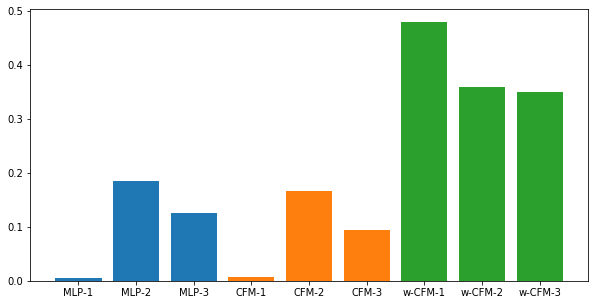

In [9]:
print(results[0])
print(results[1])
print(w_res)

fig = plt.figure(figsize=(10,5))
fig = plt.bar(x=['MLP-1', 'MLP-2', 'MLP-3'], height=results[0])
fig = plt.bar(x=['CFM-1', 'CFM-2', 'CFM-3'], height=results[1])
fig = plt.bar(x=['w-CFM-1', 'w-CFM-2', 'w-CFM-3'], height=w_res)